# Performing the Higgs -> WW-> l leptons search 

##  Cut-based analysis

Focus on discriminating Higgs signal from irreducible SM WW production.

Final state is 2 leptons + missing tranverse momentum.








# Installation of packages not available by default on colab


In [1]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib


#!pip install vector
#!pip install hist

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:

import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
fn2="https://cernbox.cern.ch/remote.php/dav/public-files/6mTuRapglPXnwUT/hww_atlas.csv.gz" #hww
totf2=600000
#fn1="https://cernbox.cern.ch/remote.php/dav/public-files/bt9p3KS952M0I11/ttlep_atlas.csv.gz" #ttlep
fn1="https://cernbox.cern.ch/remote.php/dav/public-files/ndKtAQHMxNUmumC/ww_atlas.csv.gz" #ww
totf1=600000

N = 10000
print("Size of dataset : %i"%N)
df1 = pd.read_csv(fn1, compression='gzip', header=0,nrows=N,engine='python')
df2 = pd.read_csv(fn2, compression='gzip', header=0,nrows=N,engine='python')


Size of dataset : 10000


In [4]:
# add labelling signal/background
df1['SIG']=0
df2['SIG']=1


dftot=pd.concat([df1,df2])

#
# create array of 4-vectors of two leptons and etmiss for calculation of derived
# variables
#
p4l1=vector.array({"pt":dftot["ptl1"], "phi":dftot["phil1"],
    "eta":dftot["etal1"], "e":dftot["el1"]})
p4l2=vector.array({"pt":dftot["ptl2"], "phi":dftot["phil2"],
    "eta":dftot["etal2"], "e":dftot["el2"]})
etmv=vector.array({"pt":dftot["met_et"], "phi":dftot["met_phi"]})

#
#  rotate variables to exploit azimuthal symmetry
#
dftot["dphil1m"]=p4l1.deltaphi(etmv)
dftot["dphil2m"]=p4l2.deltaphi(etmv)

#  High level variables for 2-l+etm system
#
p4ll=p4l1+p4l2
dftot["dphill"]=p4l1.deltaphi(p4l2)
dftot["dphillm"]=p4ll.deltaphi(etmv)
ptll=p4ll.pt
mll=p4ll.M
dftot["ptll"]=ptll
dftot["mll"]=mll

#   drop redundant variables
#
df=dftot.drop(columns=['phil1','phil2','met_phi'])

coln=df.columns

print(coln)

print(df.head())

print(df.info())

Index(['ptl1', 'etal1', 'el1', 'chl1', 'typl1', 'ptl2', 'etal2', 'el2', 'chl2',
       'typl2', 'met_et', 'jet_n', 'totalWeight', 'SIG', 'dphil1m', 'dphil2m',
       'dphill', 'dphillm', 'ptll', 'mll'],
      dtype='object')
           ptl1     etal1           el1  chl1  typl1          ptl2     etal2  \
0  66719.210938  0.302357  69792.250000   1.0   11.0  38223.332031  1.466256   
1  29149.914062  1.102973  48753.128906  -1.0   11.0  29030.730469 -0.051656   
2  52254.113281 -0.618223  62562.000000   1.0   11.0  43302.742188 -1.738426   
3  33380.015625  0.246225  34397.000000   1.0   11.0  29918.826172  0.042298   
4  36902.187500  1.114667  62301.644531  -1.0   13.0  31770.462891  1.025301   

             el2  chl2  typl2      met_et  jet_n  totalWeight  SIG   dphil1m  \
0   87221.343750  -1.0   13.0  130877.860      6     0.014754    0  0.838801   
1   29069.662109   1.0   13.0   36958.645      1     0.090498    0  2.747738   
2  126967.546875  -1.0   13.0   42118.477      1     0

## Apply preselections or add secondary variables if desired to separate datafranes

Define routine which loops over all the samples in the dictionary of dataframes and applies
selections on them. <br />
It would be simpler to apply the cuts when reading the files, but in this way you can play with 
the selections without the need of reloading the files every time<br />
One can also create dataframes with different selection levels and compare them

## Look at signal and background statistics after reading data

In [5]:
def getnormev(df,totsig,totbg,evread):
  nsigw=((df.query("SIG==1"))["totalWeight"]).sum()*totsig/evread
  nbgw=((df.query("SIG==0"))["totalWeight"]).sum()*totbg/evread
  return nsigw,nbgw

nsigw,nbgw=getnormev(df,totf2,totf1,N)
print(nsigw,nbgw)


473.09703183599987 26970.569601018


## Calculation of significance

In [6]:
from math import sqrt, log
def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

In [7]:
print("significance is ",calc_sig(nsigw,nbgw,0.01*nbgw))

significance is  1.4907167185777639


In [8]:
tfea = ['SIG','ptl1','ptl2','dphil1m','dphil2m','etal1','etal2','met_et','mll','ptll','dphill','dphillm','totalWeight'] # list of features for discriminant analysis
# concatenate all samples
df_all=df[tfea]
df_all.columns=tfea
#print(df_all.keys)
# randomize it
df_all=df_all.sample(frac=1)
# kludge, put reasonable upper limit on unbounded variables to allow automatic plotting
# in a reasobnable range
df_all=df_all.query("ptl1<300000 & ptl2<250000 & met_et<300000 & mll<300000 & ptll<300000")
print("df_all ", df_all.shape)
split=1000000
df_val=df_all[split:]
print("df_val ", df_val.shape)
df_all=df_all[:split]
print("df_all ", df_all.shape)

df_all  (19447, 13)
df_val  (0, 13)
df_all  (19447, 13)


# Go for cut-based analysis

First step is visual inspection of  all variables in dataframe to find the ones with best discriminating power.
We will use some standard tools for the inspection

Use seaborn library https://seaborn.pydata.orgto get a synoptic view of all variables

First one-dimensional

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


4


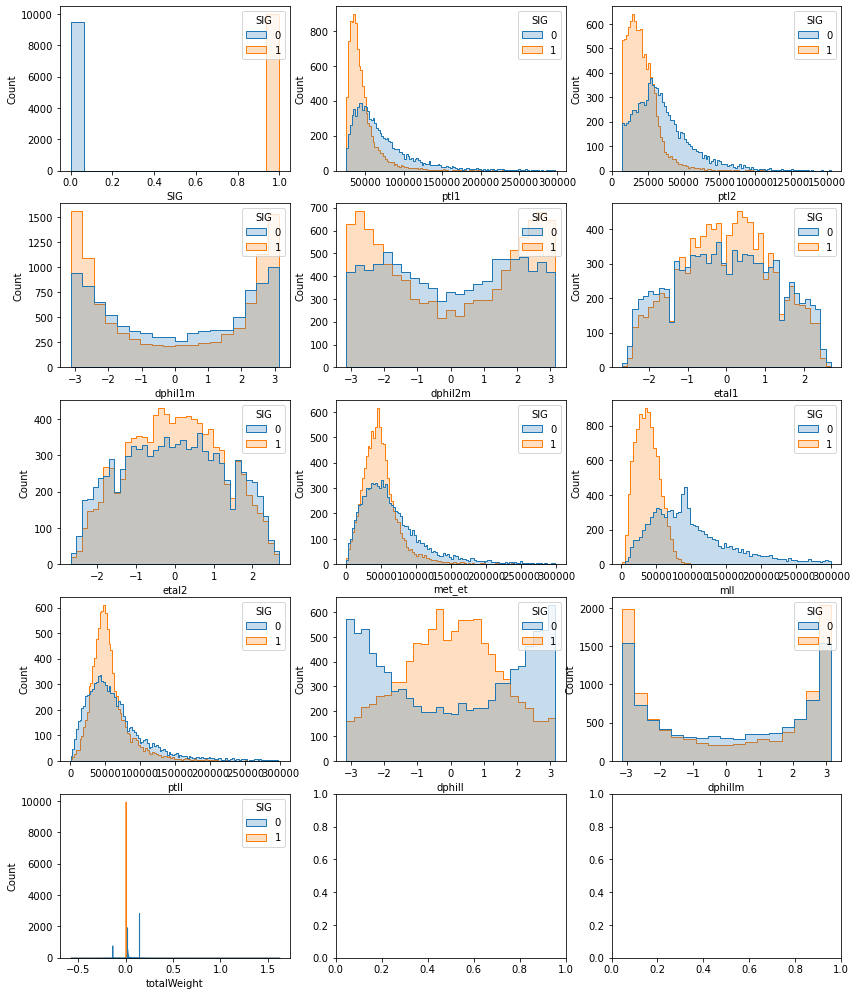

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at variables: first basic kinematics
nrow = int(len(tfea)/3)
print(nrow)
print 
if(len(tfea)%3>0):
  nrow=nrow+1
if nrow==0:
  nrow=1;
fig, axes = plt.subplots(nrow,3  , figsize=(14, 3.5*nrow))
for ii in range (0, len(tfea)):
  idf=ii
  i1=int(ii/3)
  i2=ii%3
  sns.histplot( df_all, ax=axes[i1,i2], x=tfea[idf], hue="SIG",element="step")
plt.show()

Then bidimensional for promising variables

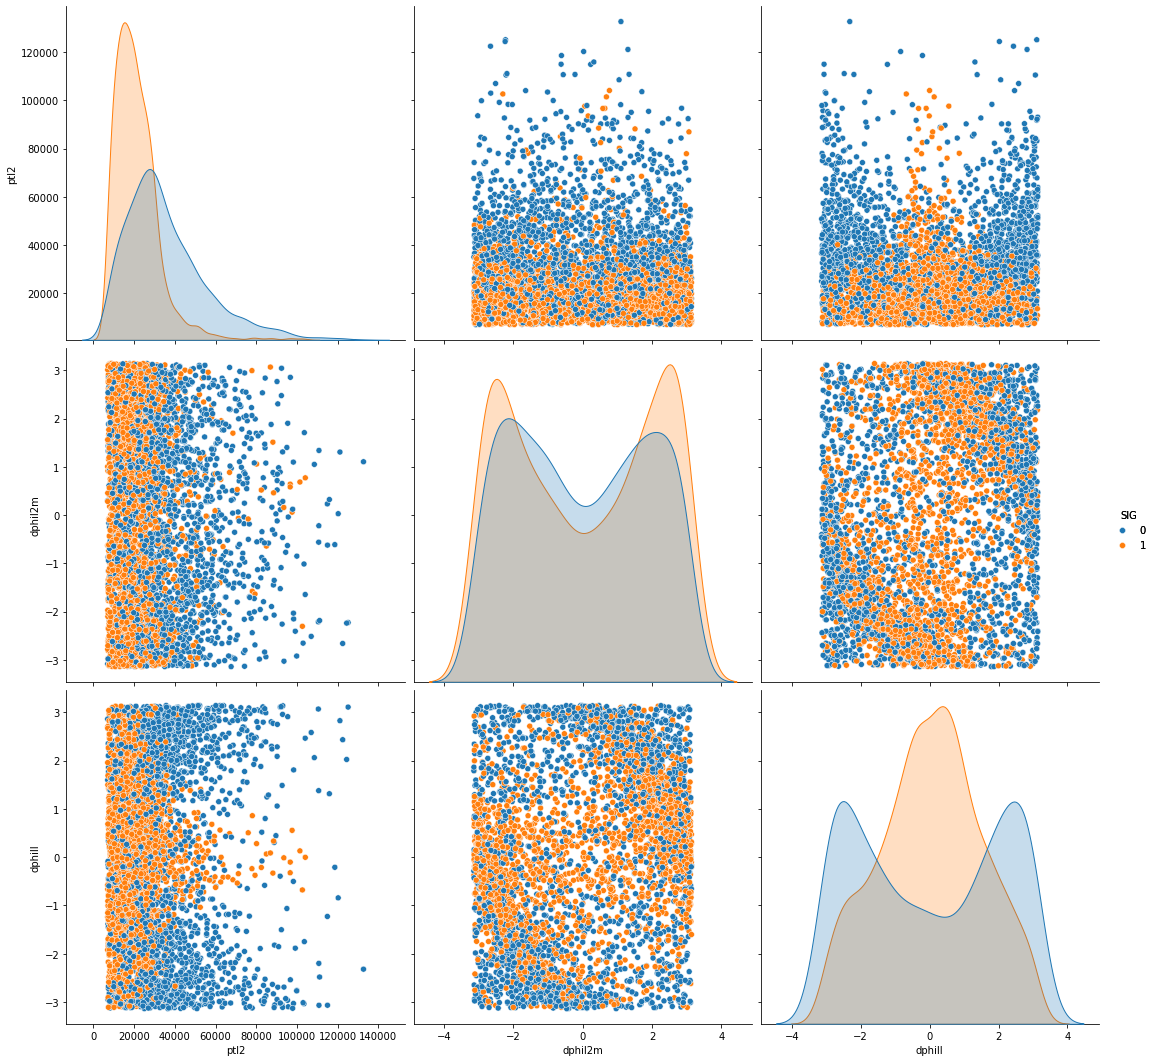

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

dfsmall=df_all.head(5000) 
g = sns.pairplot(dfsmall, vars=["ptl2", "dphil2m","dphill"], hue="SIG",height=5)
#g = sns.PairGrid(df1, vars=["MET_val", "MET_rel","axial_MET"], hue="SIG",height=5)
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot, s=20)
g.add_legend()

## Free Plotting

Set simple wrapper for plotting histograms with matplotlib

In [11]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

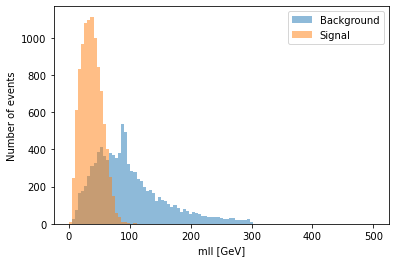

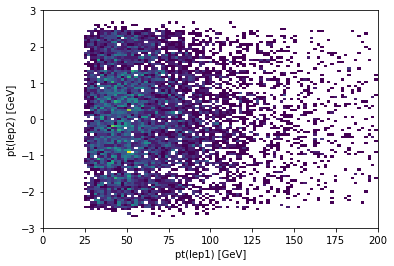

In [12]:
MeV=0.001
hist1d(df_all.query("SIG==0"),"mll",MeV,100,0.,500.,False,'mll [GeV]','Number of events','','Background')
hist1d(df_all.query("SIG==1"),"mll",MeV,100,0.,500.,False,'mll [GeV]','Number of events','Unscaled','Signal')
plt.show()
hist2d(df_all.query("SIG==0"),"ptl1","etal1",MeV,1,100,0.,200.,100,-3.,3.,'pt(lep1) [GeV]','pt(lep2) [GeV]','')
plt.show()

In [13]:
def plot_varsel(df, sel1, sel2, var, blow, bhigh, nbin):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  bins = np.linspace(blow, bhigh, nbin)
  plt.hist(df_pass[var], bins, alpha=0.5, density=True, label=sel1)
  plt.hist(df_nopass[var], bins, alpha=0.5, density=True, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var)
  plt.ylabel('normalised events')
  plt.show()

In [14]:
string="mll<80000 and mll>25000 and ptl1<70000 and abs(dphill)<1.8"
df_all_s=df_all.query(string)



In [15]:
numsig,numbg=getnormev(df_all_s,totf2,totf1,N)
print(nsigw,nbgw)
print('after cuts; signal:',numsig,' background:',numbg)
print("significance is:",calc_sig(numsig, numbg,0.01*numbg))


473.09703183599987 26970.569601018
after cuts; signal: 199.206251706  background: 4218.17688138
significance is: 2.5465440349525648


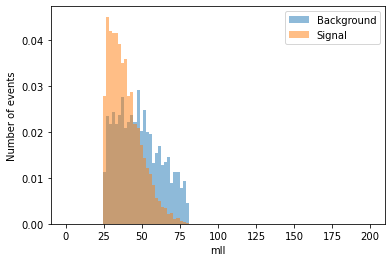

In [16]:
hist1d(df_all_s.query("SIG==0"),"mll",MeV,100,0.,200.,True,'mll','Number of events','','Background')
hist1d(df_all_s.query("SIG==1"),"mll",MeV,100,0.,200.,True,'mll','Number of events','','Signal')
plt.show()

## Exercises



* Play around with cuts trying to achieve the best possible significance when fighting with WW background
    * Implement the mT variable defined as 
    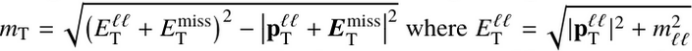
    <br />
    (hint:ptllv=vector.array({"x":p4ll.x, "y":p4ll.y}))<br />
    in the ATLAS WW paper https://www.sciencedirect.com/science/article/pii/S0370269318309936?via%3Dihub
    and verify the impact on the analysis
* Replace WW background with ttbar background and try same exercise.<br /> 
    Hints: 
     * number of jets become important.
     * build the variable corresponding to the modulus of the vector sum of the transverse momenta  of the two lepton and Etmiss.<br />Add it to the dataframe and verify whether it is a good discriminant variable